In [1]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
import pandas as pd
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

In [2]:
def load_results(DATASET, full):
    if not full:
        with open(f'{ROOT_DIR}/results/{DATASET}_scores.pkl', 'rb') as f :
            results = pickle.load(f)
    else:
        with open(f'{ROOT_DIR}/results/{DATASET}_scores_full.pkl', 'rb') as f :
            results = pickle.load(f)
    return results
    
def bootstrap_ci(data, alpha=0.95):
    estimates = {}
    for c in data:
        estimates[c]={}
        for arch in data[c]:
            res = data[c][arch]
            median = np.mean(res)
            bs_reps = bootstrap(np.array(res).reshape(1,-1), statistic=np.mean, n_resamples=1000)
            ci = bs_reps.confidence_interval[0:2]
            estimates[c][arch] = (median, ci[0], ci[1])
    return estimates

def bootstrap_samples(data, n_iterations):
    n = len(data)
    indices = np.random.randint(0, n, (n_iterations, n))
    return data[indices]

def get_difference_estimates(results):
    results_diff = {}
    n_iterations = 1000
    for cost in results:
        results_diff[cost] = {}
        for architecture in list(results[cost].keys())[1:]:
            single = np.array(results[cost]['single'])
            other = np.array(results[cost][architecture])
            bs_single_samples = bootstrap_samples(single, n_iterations)
            bs_other_samples = bootstrap_samples(other, n_iterations)
            bs_single_means = np.median(bs_single_samples, axis=1)
            bs_other_means = np.median(bs_other_samples, axis=1)
            bs_diff = bs_other_means - bs_single_means 
            mean_single = np.median(single)
            median_diff = 100 * np.percentile(bs_diff, 50) / mean_single
            lower_ci_diff = 100 * np.percentile(bs_diff, 5) / mean_single
            upper_ci_diff = 100 * np.percentile(bs_diff, 95) / mean_single
            results_diff[cost][architecture] = (np.round(median_diff, 3), np.round(lower_ci_diff, 3), np.round(upper_ci_diff, 3))
    return pd.DataFrame.from_dict(results_diff, orient='index')

def print_med_results(DATASET, full = True):
   if full:
      results = load_results(DATASET, full)
      for arch in ['single', 'joint', 'federated', 'pfedme', 'ditto']:
         print(arch)
         for c in results:
            print(np.median(results[c][arch]))
         print('----')
   else:
      results = load_results(DATASET, full)
      for arch in ['single', 'joint']:
         print(arch)
         for c in results:
            print(np.median(results[c][arch]))
         print('----')

def grapher(results, DATASET, metric, costs, save):
    results_long = results.reset_index().rename(columns={'index': 'cost'}).melt(id_vars=['cost'], var_name='architecture')
    results_long[['median_diff', 'lower_ci_diff', 'upper_ci_diff']] = pd.DataFrame(results_long['value'].tolist(), index=results_long.index)
    results_long.drop(columns=['value'], inplace=True)
    results_long
    plt.figure()
    for architecture in results_long['architecture'].unique():
        subset = results_long[results_long['architecture'] == architecture]
        sns.lineplot(x='cost', y='median_diff', marker = 'o', data=subset, label=architecture.capitalize())
        plt.fill_between(x=subset['cost'], y1=subset['lower_ci_diff'], y2=subset['upper_ci_diff'], alpha=0.2)
    plt.axhline(y=0, color='black', linestyle = '--', alpha = 0.5, label = 'Baseline')
    plt.xlabel('Dataset Cost', fontsize = 14)
    plt.ylabel(f'% Change in {metric}', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    if save == True:
        plt.savefig(f'{SAVE_DIR}/{DATASET}/{metric}_{costs}_change.pdf', bbox_inches='tight')
    plt.show()

def process_results(DATASET, full = False):
    dataset_dict = {'Synthetic':['F1', '0.03-0.6'],
                'Credit': ['F1', '0.12-0.40'],
                'Weather': ['R2', '0.11-0.48'],
                'EMNIST': ['Accuracy', '0.11-0.39'],
                'CIFAR': ['Accuracy', '0.08-0.38'],
                'ISIC': ['Balanced Accuracy', '0.06-0.30'],
                'IXITiny': ['DICE', '0.08-0.30']}

    results = load_results(DATASET, full)
    results_estimates = bootstrap_ci(results, alpha=0.95)
    results_diff_estimates = get_difference_estimates(results)
    metric, costs = dataset_dict[DATASET]
    save = False
    grapher(results_diff_estimates, DATASET, metric, costs, save)
    return 

## JOINT

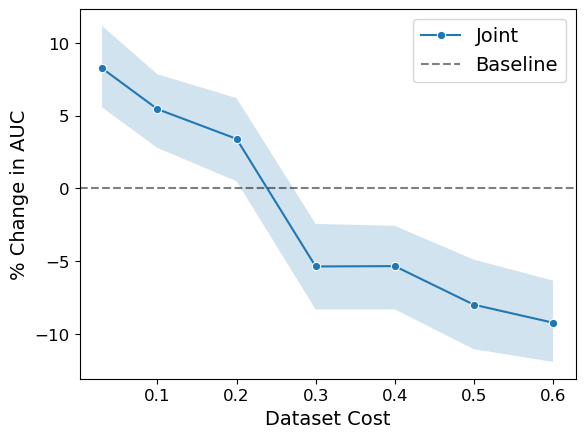

In [625]:
DATASET = 'Synthetic'
process_results(DATASET)

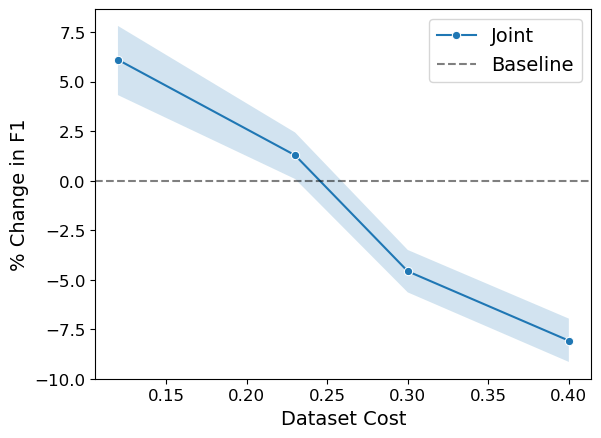

In [626]:
DATASET = 'Credit'
process_results(DATASET)

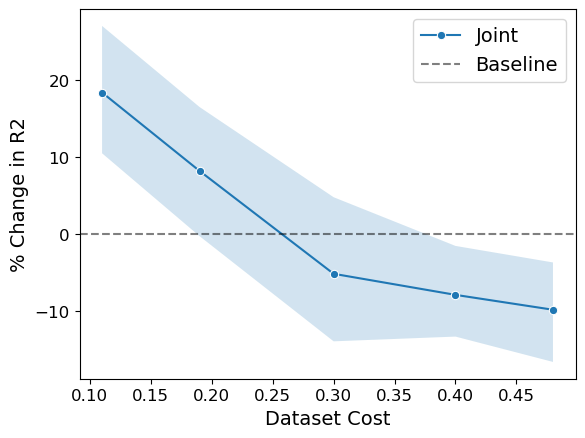

In [627]:
DATASET = 'Weather'
process_results(DATASET)

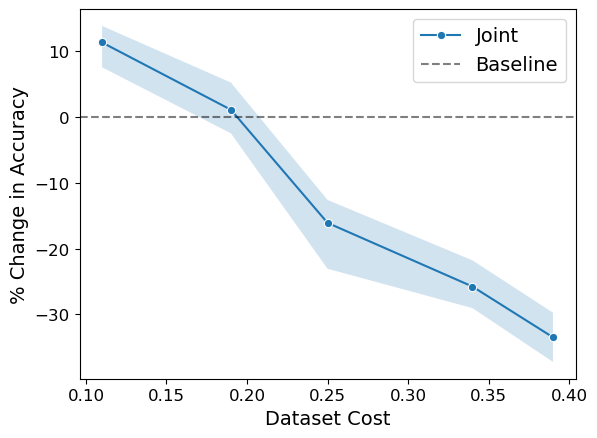

In [201]:
DATASET = 'EMNIST'
process_results(DATASET)

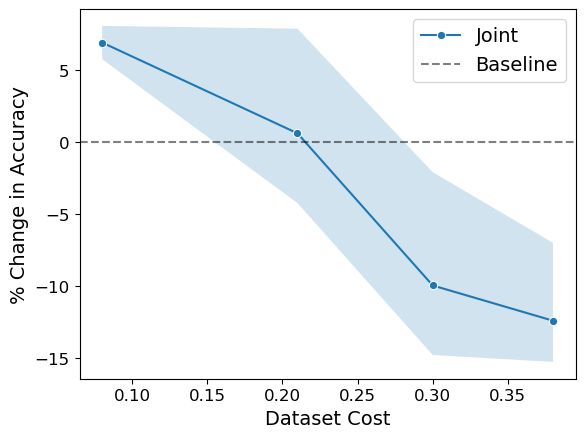

In [204]:
DATASET = 'CIFAR'
process_results(DATASET)

In [205]:
print_med_results(DATASET, full = False)

single
0.87
0.8274999999999999
0.83
0.7875000000000001
----
joint
0.93
0.83
0.745
0.69
----


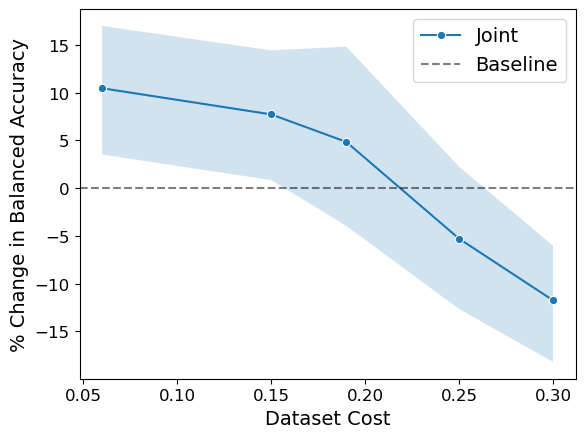

In [140]:
DATASET = 'ISIC'
process_results(DATASET)

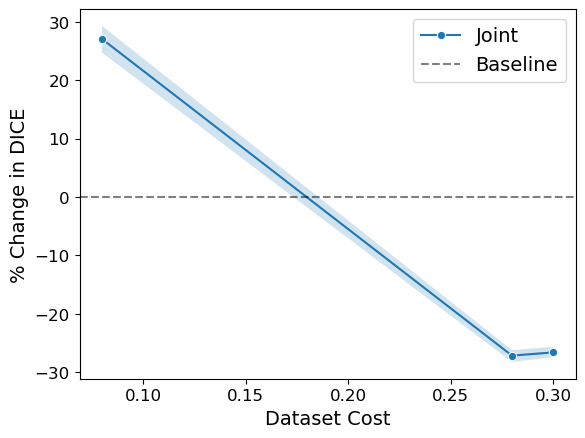

In [141]:
DATASET = 'IXITiny'
process_results(DATASET)

## FULL

In [5]:
full = True

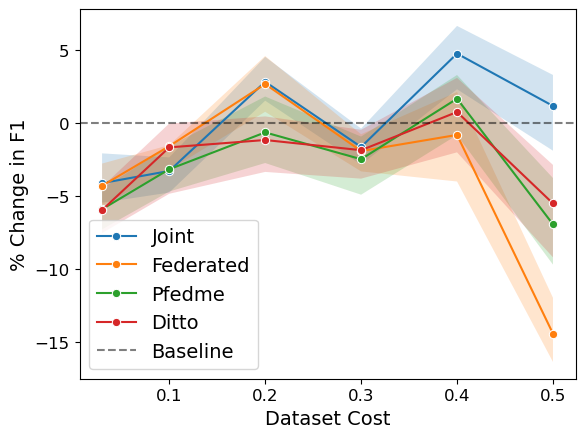

In [13]:
DATASET = 'Synthetic'
process_results(DATASET, full)

In [14]:
print_med_results(DATASET, full = True)

single
0.6861407249466951
0.6774193548387097
0.7705802968960864
0.7
0.7034640274076894
0.6190476190476191
----
joint
0.6569296375266525
0.6551724137931034
0.7936507936507936
0.6885245901639345
0.7376518218623481
0.6282476506357104
----
federated
0.65625
0.6666666666666666
0.7936507936507936
0.6870335820895523
0.6984126984126984
0.5306122448979592
----
pfedme
0.6451612903225806
0.6559938524590163
0.7666666666666666
0.6818889465490399
0.7164179104477613
0.5746031746031747
----
ditto
0.6451612903225806
0.6666666666666666
0.761234071093226
0.6867280485066247
0.7105263157894737
0.5853658536585367
----


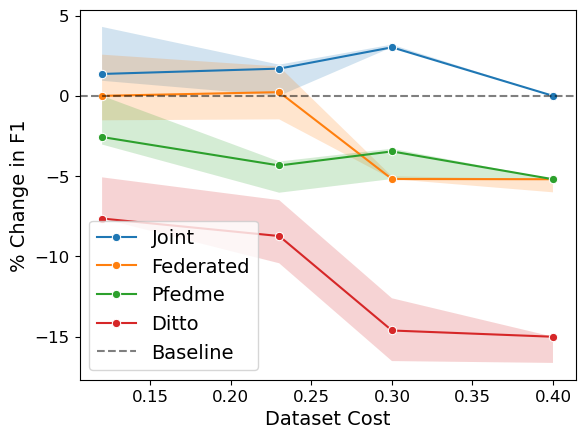

In [15]:
DATASET = 'Credit'
process_results(DATASET, full)

In [10]:
print_med_results(DATASET, full = True)

single
0.85
0.84
0.888888888888889
0.9491525423728813
----
joint
0.9157955865272938
0.8627450980392156
0.888888888888889
0.9666666666666666
----
federated
0.8472222222222222
0.8516483516483516
0.8455843469063988
0.8332761578044597
----
pfedme
0.8421052631578948
0.782608695652174
0.870967741935484
0.8518518518518519
----
ditto
0.8421052631578948
0.782608695652174
0.7499999999999999
0.8076923076923077
----


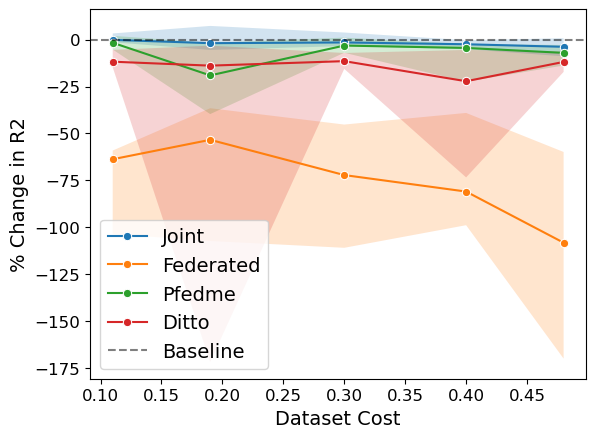

In [11]:
DATASET = 'Weather'
process_results(DATASET, full)

In [12]:
print_med_results(DATASET, full = True)

single
0.8756161554204502
0.8684667602966801
0.9033419644254417
0.88970315602753
0.8620022100553943
----
joint
0.8744689239073895
0.8519215232532645
0.8896458696768654
0.8677048238488113
0.8289890764936021
----
federated
0.317263005761905
0.4046312511514776
0.25110894302521525
0.1690746383060362
-0.07110320329160214
----
pfedme
0.860961880444326
0.7028021612735322
0.874637124874067
0.8502076970619484
0.8070442311465525
----
ditto
0.7725442709114405
0.7205141703438298
0.7996544643557769
0.6923522086085613
0.7594334044879412
----


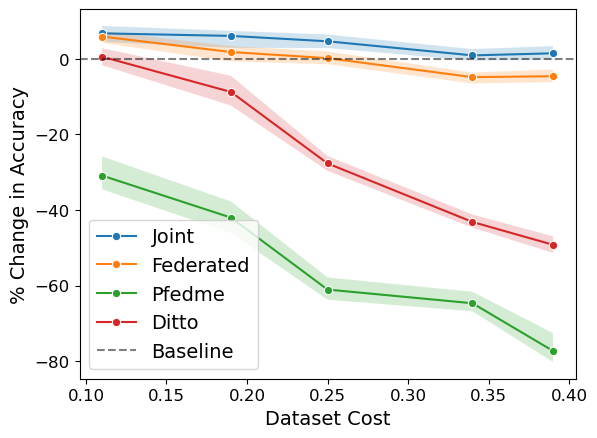

In [210]:
DATASET = 'EMNIST'
process_results(DATASET, full)

In [208]:
print_med_results(DATASET, full = True)

single
0.89
0.7946428571428571
0.7777777777777778
0.825
0.89
----
joint
0.9475
0.8410714285714286
0.8138888888888889
0.8325
0.902
----
federated
0.9424999999999999
0.8089285714285714
0.7791666666666667
0.7849999999999999
0.848
----
pfedme
0.6174999999999999
0.4589285714285714
0.30138888888888893
0.29
0.197
----
ditto
0.895
0.725
0.5597222222222222
0.46875
0.448
----


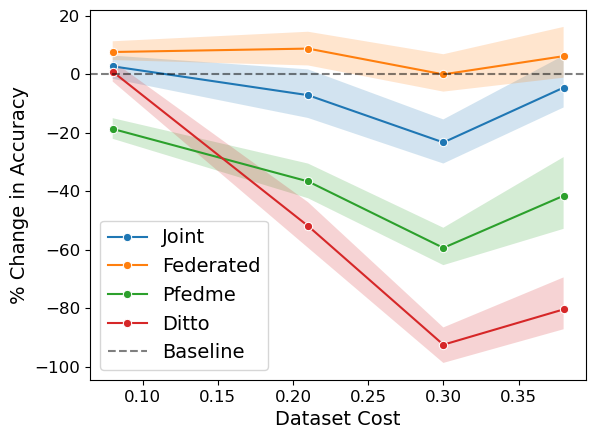

In [216]:
DATASET = 'CIFAR'
process_results(DATASET, full)

In [197]:
print_med_results(DATASET, full = True)

single
0.8174999999999999
----
joint
0.84
----
federated
0.88
----
pfedme
0.665
----
ditto
0.8274999999999999
----


/gpfs/commons/home/aelhussein/anaconda3/envs/cuda_env/lib/python3.9/site-packages/scipy/stats/_resampling.py:118: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = num / den
/gpfs/commons/home/aelhussein/anaconda3/envs/cuda_env/lib/python3.9/site-packages/scipy/stats/_resampling.py:92: DegenerateDataWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(DegenerateDataWarning(msg))


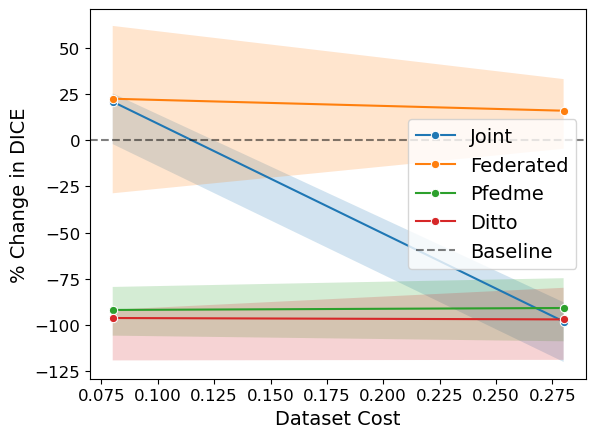

In [6]:
DATASET = 'IXITiny'
process_results(DATASET, full)

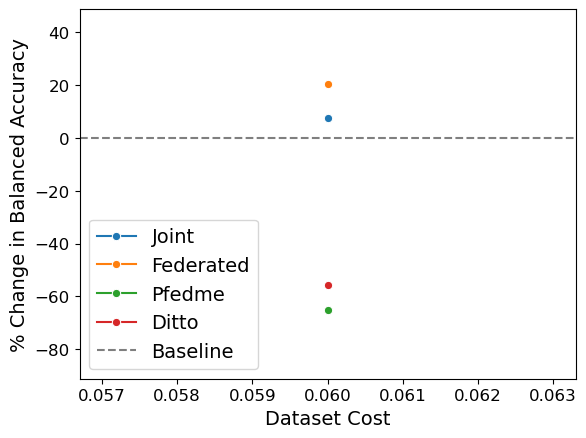

In [7]:
DATASET = 'ISIC'
process_results(DATASET, full)